In [575]:
import os
import numpy as np 
import pandas as pd
from tqdm import tqdm

import SimpleITK as sitk

import skimage
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

In [576]:
import pickle

with open('/Users/nastya/Documents/ucu/thesis/data/mnist_split/test_mnist.pkl', "rb") as f:
    test_set = pickle.load(f)

In [577]:
test_set = [((pair[1] > 127).view(np.uint8) * 255, (pair[0] > 127).view(np.uint8) * 255) for pair in test_set]

In [578]:
def register_img_generic(fixed_arr, moving_arr, registration_func, show_transform=True):

    fixed_image = sitk.GetImageFromArray(fixed_arr)
    moving_image = sitk.GetImageFromArray(moving_arr)

    ff_img = sitk.Cast(fixed_image, sitk.sitkFloat32)
    mv_img = sitk.Cast(moving_image, sitk.sitkFloat32)

    final_transform_v1 = registration_func(ff_img, mv_img)

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    resample.SetInterpolator(sitk.sitkBSpline)
    resample.SetTransform(final_transform_v1)
    
    if show_transform:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
        xx, yy = np.meshgrid(range(moving_arr.shape[0]), range(moving_arr.shape[1]))
        test_pattern = (((xx % 40)>30)|((yy % 40)>30)).astype(np.float32)
        ax1.imshow(test_pattern, cmap = 'bone_r')
        ax1.set_title('Test Pattern')
        test_pattern_img = sitk.GetImageFromArray(test_pattern)
        skew_pattern = sitk.GetArrayFromImage(resample.Execute(test_pattern_img))
        ax2.imshow(skew_pattern, cmap = 'bone_r')
        ax2.set_title('Registered Pattern')
        
    return sitk.GetArrayFromImage(resample.Execute(moving_image))

In [579]:
def bspline_intra_modal_registration(fixed_image, moving_image, grid_physical_spacing=[15.0] * 3):
    
    registration_method = sitk.ImageRegistrationMethod()
    # Determine the number of BSpline control points using the physical spacing we want for the control grid.
    
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]
    # print('Using Mesh Size', mesh_size)
    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image,
                                                         transformDomainMeshSize = mesh_size, order=3)
    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.75)

    # Multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    # registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    registration_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=1.0,
        minStep=1e-4,
        numberOfIterations=100,
        gradientMagnitudeTolerance=1e-8,
    )
    
    return registration_method.Execute(fixed_image, moving_image)

### Registration + metrics

In [580]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [581]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [582]:
import time

dice_scores = []
mse_scores = []

registered_images = []

start_time = time.time()

for idx, (source_image, target_image) in tqdm(enumerate(test_set)):

    source_image_warp = register_img_generic(target_image, source_image, registration_func=bspline_intra_modal_registration, show_transform=False)

    registered_images.append(source_image_warp)

    source_image_warp_float = source_image_warp.astype(np.float64) / 255.0
    target_image_float = target_image.astype(np.float64) / 255.0
    
    dice = dice_score(source_image_warp_float, target_image_float)
    mse = mean_squared_error(source_image_warp_float, target_image_float)

    dice_scores.append(dice)
    mse_scores.append(mse)  

end_time = time.time() - start_time
print(end_time)

542it [00:21, 24.90it/s]

21.770621061325073


In [583]:
metrics_data = pd.DataFrame({
    'dice': dice_scores,
    'mse': mse_scores
})

In [584]:
metrics_data['mse'].mean()

0.05375903950321899

In [585]:
metrics_data['dice'].mean()

0.7333205735534216

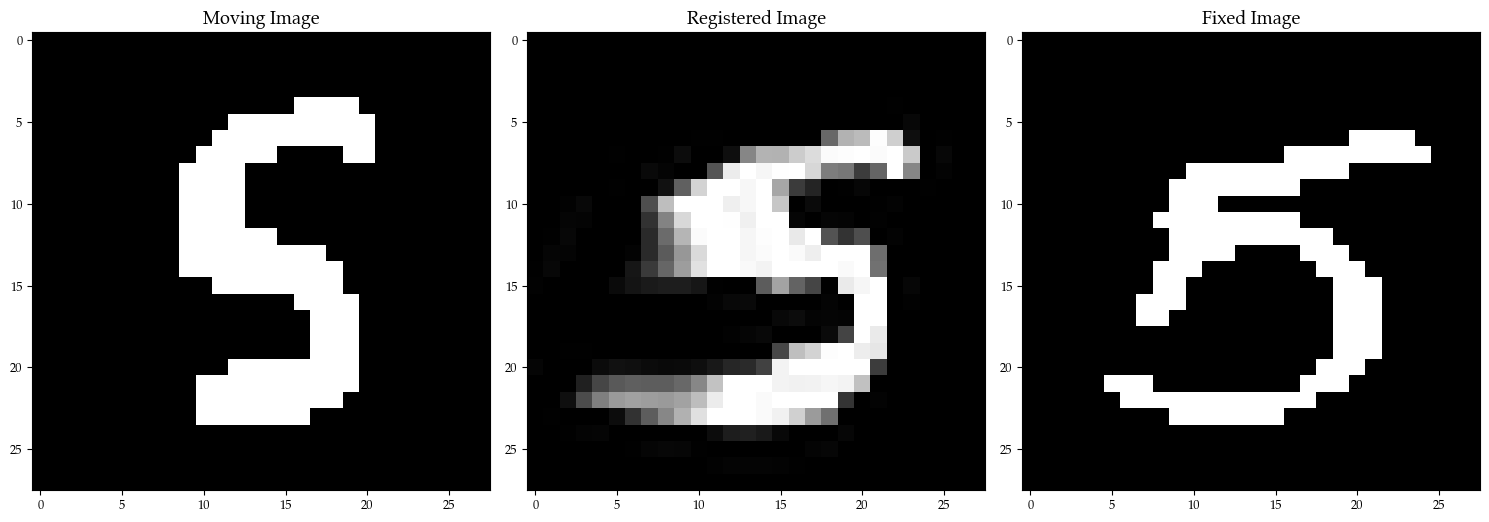

In [586]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[65] ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(test_set[65][1] ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(test_set[65][0] ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

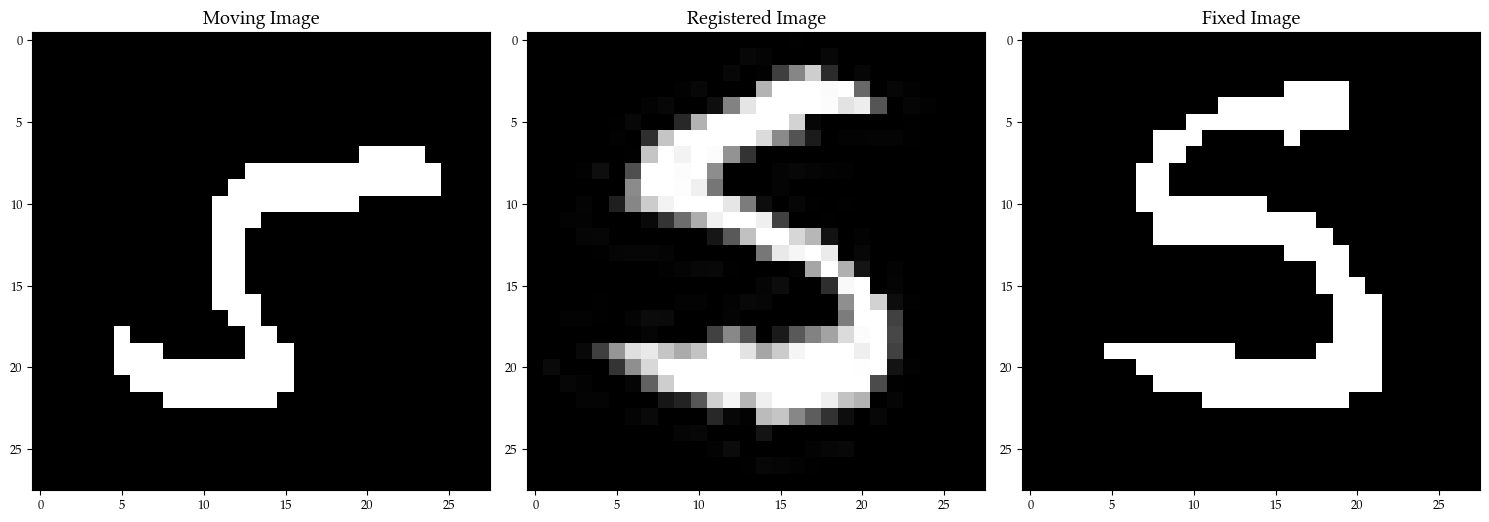

In [587]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[34] ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(test_set[34][1] ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(test_set[34][0] ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

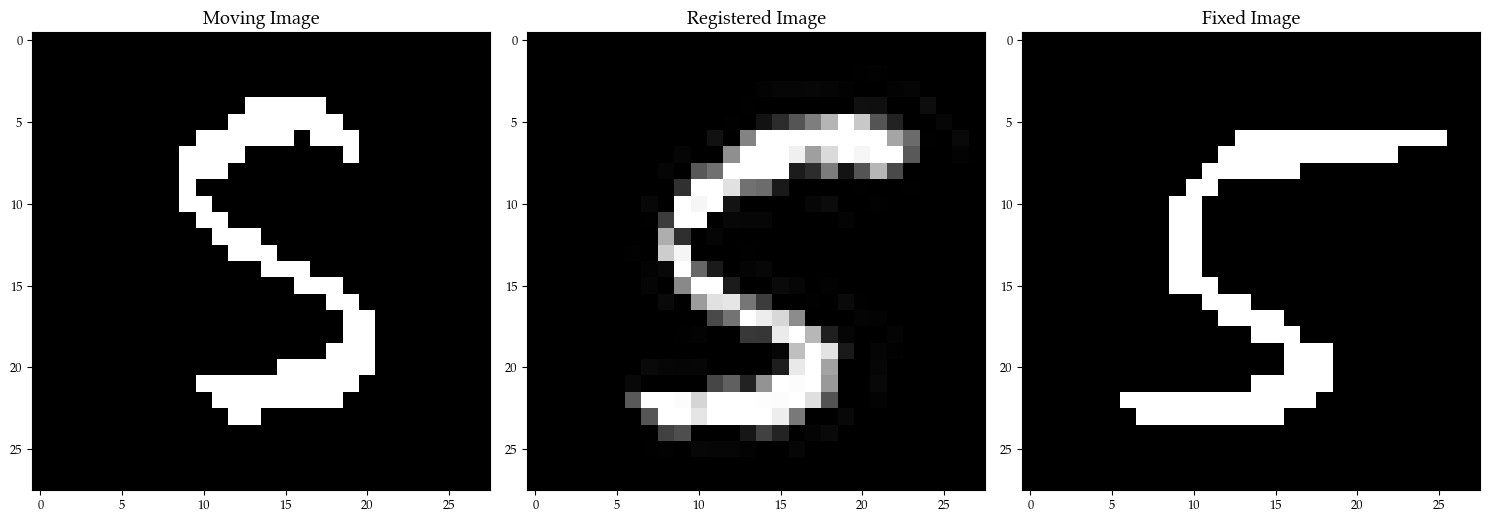

In [588]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[0] ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(test_set[0][1] ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(test_set[0][0] ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()